## Javier Mombiela
## Carnet: 20067
## 12 de abril 2024

### Proyecto 2: “Entrenamiento Incremental en Modelos de Deep Learning y Machine Learning

Importando librerias

In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

### Analasis Exploratorio

In [2]:
df = pd.read_csv('fraud_feature_engineering_example.csv')

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,amt_month,amt_year,amt_month_shopping_net_spend,count_month_shopping_net,first_time_at_merchant
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,4.97,4.97,0.0,0.0,True
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,107.23,107.23,0.0,0.0,True
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,220.11,220.11,0.0,0.0,True
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,45.00,45.00,0.0,0.0,True
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,41.96,41.96,0.0,0.0,True


In [3]:
# Información general sobre el dataframe
print("\nInformación del dataframe:")
print(df.info())


Información del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   trans_date_trans_time         object 
 1   cc_num                        int64  
 2   merchant                      object 
 3   category                      object 
 4   amt                           float64
 5   first                         object 
 6   last                          object 
 7   gender                        object 
 8   street                        object 
 9   city                          object 
 10  state                         object 
 11  zip                           int64  
 12  lat                           float64
 13  long                          float64
 14  city_pop                      int64  
 15  job                           object 
 16  dob                           object 
 17  trans_num                     object 

In [4]:
# Verificar valores faltantes en el conjunto de datos
missing_values = df.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

Valores faltantes por columna:
trans_date_trans_time           0
cc_num                          0
merchant                        0
category                        0
amt                             0
first                           0
last                            0
gender                          0
street                          0
city                            0
state                           0
zip                             0
lat                             0
long                            0
city_pop                        0
job                             0
dob                             0
trans_num                       0
unix_time                       0
merch_lat                       0
merch_long                      0
is_fraud                        0
amt_month                       0
amt_year                        0
amt_month_shopping_net_spend    0
count_month_shopping_net        0
first_time_at_merchant          0
dtype: int64


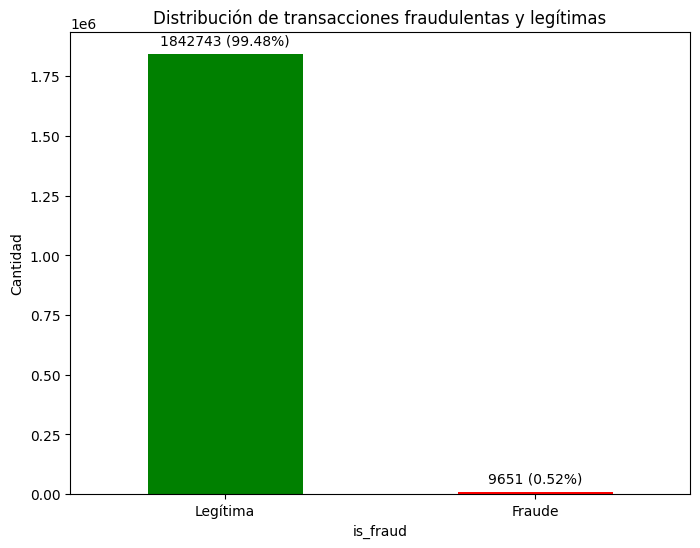

In [5]:
# Calcular la cantidad de transacciones fraudulentas y legítimas
fraud_counts = df['is_fraud'].value_counts()
total_transactions = fraud_counts.sum()

# Visualizar la distribución de la variable objetivo 'is_fraud'
plt.figure(figsize=(8, 6))
fraud_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de transacciones fraudulentas y legítimas')
plt.xlabel('is_fraud')
plt.ylabel('Cantidad')
plt.xticks([0, 1], ['Legítima', 'Fraude'], rotation=0)

# Mostrar la proporción en el gráfico
for i, count in enumerate(fraud_counts):
    plt.text(i, count + total_transactions * 0.02, f"{count} ({count / total_transactions:.2%})", ha='center')

plt.show()

In [6]:
# Calcular estadísticas descriptivas para características numéricas
numeric_features = df.select_dtypes(include=['float64', 'int64'])
numeric_summary = numeric_features.describe()
print("Estadísticas descriptivas para características numéricas:")
print(numeric_summary)

Estadísticas descriptivas para características numéricas:
             cc_num           amt           zip           lat          long  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   4.173860e+17  7.006357e+01  4.881326e+04  3.853931e+01 -9.022783e+01   
std    1.309115e+18  1.592540e+02  2.688185e+04  5.071470e+00  1.374789e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.640000e+00  2.623700e+04  3.466890e+01 -9.679800e+01   
50%    3.521417e+15  4.745000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.310000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.992100e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   8.864367e+04  1.358674e+09  3.853898e+01 -9.022794e+01  5.210015e

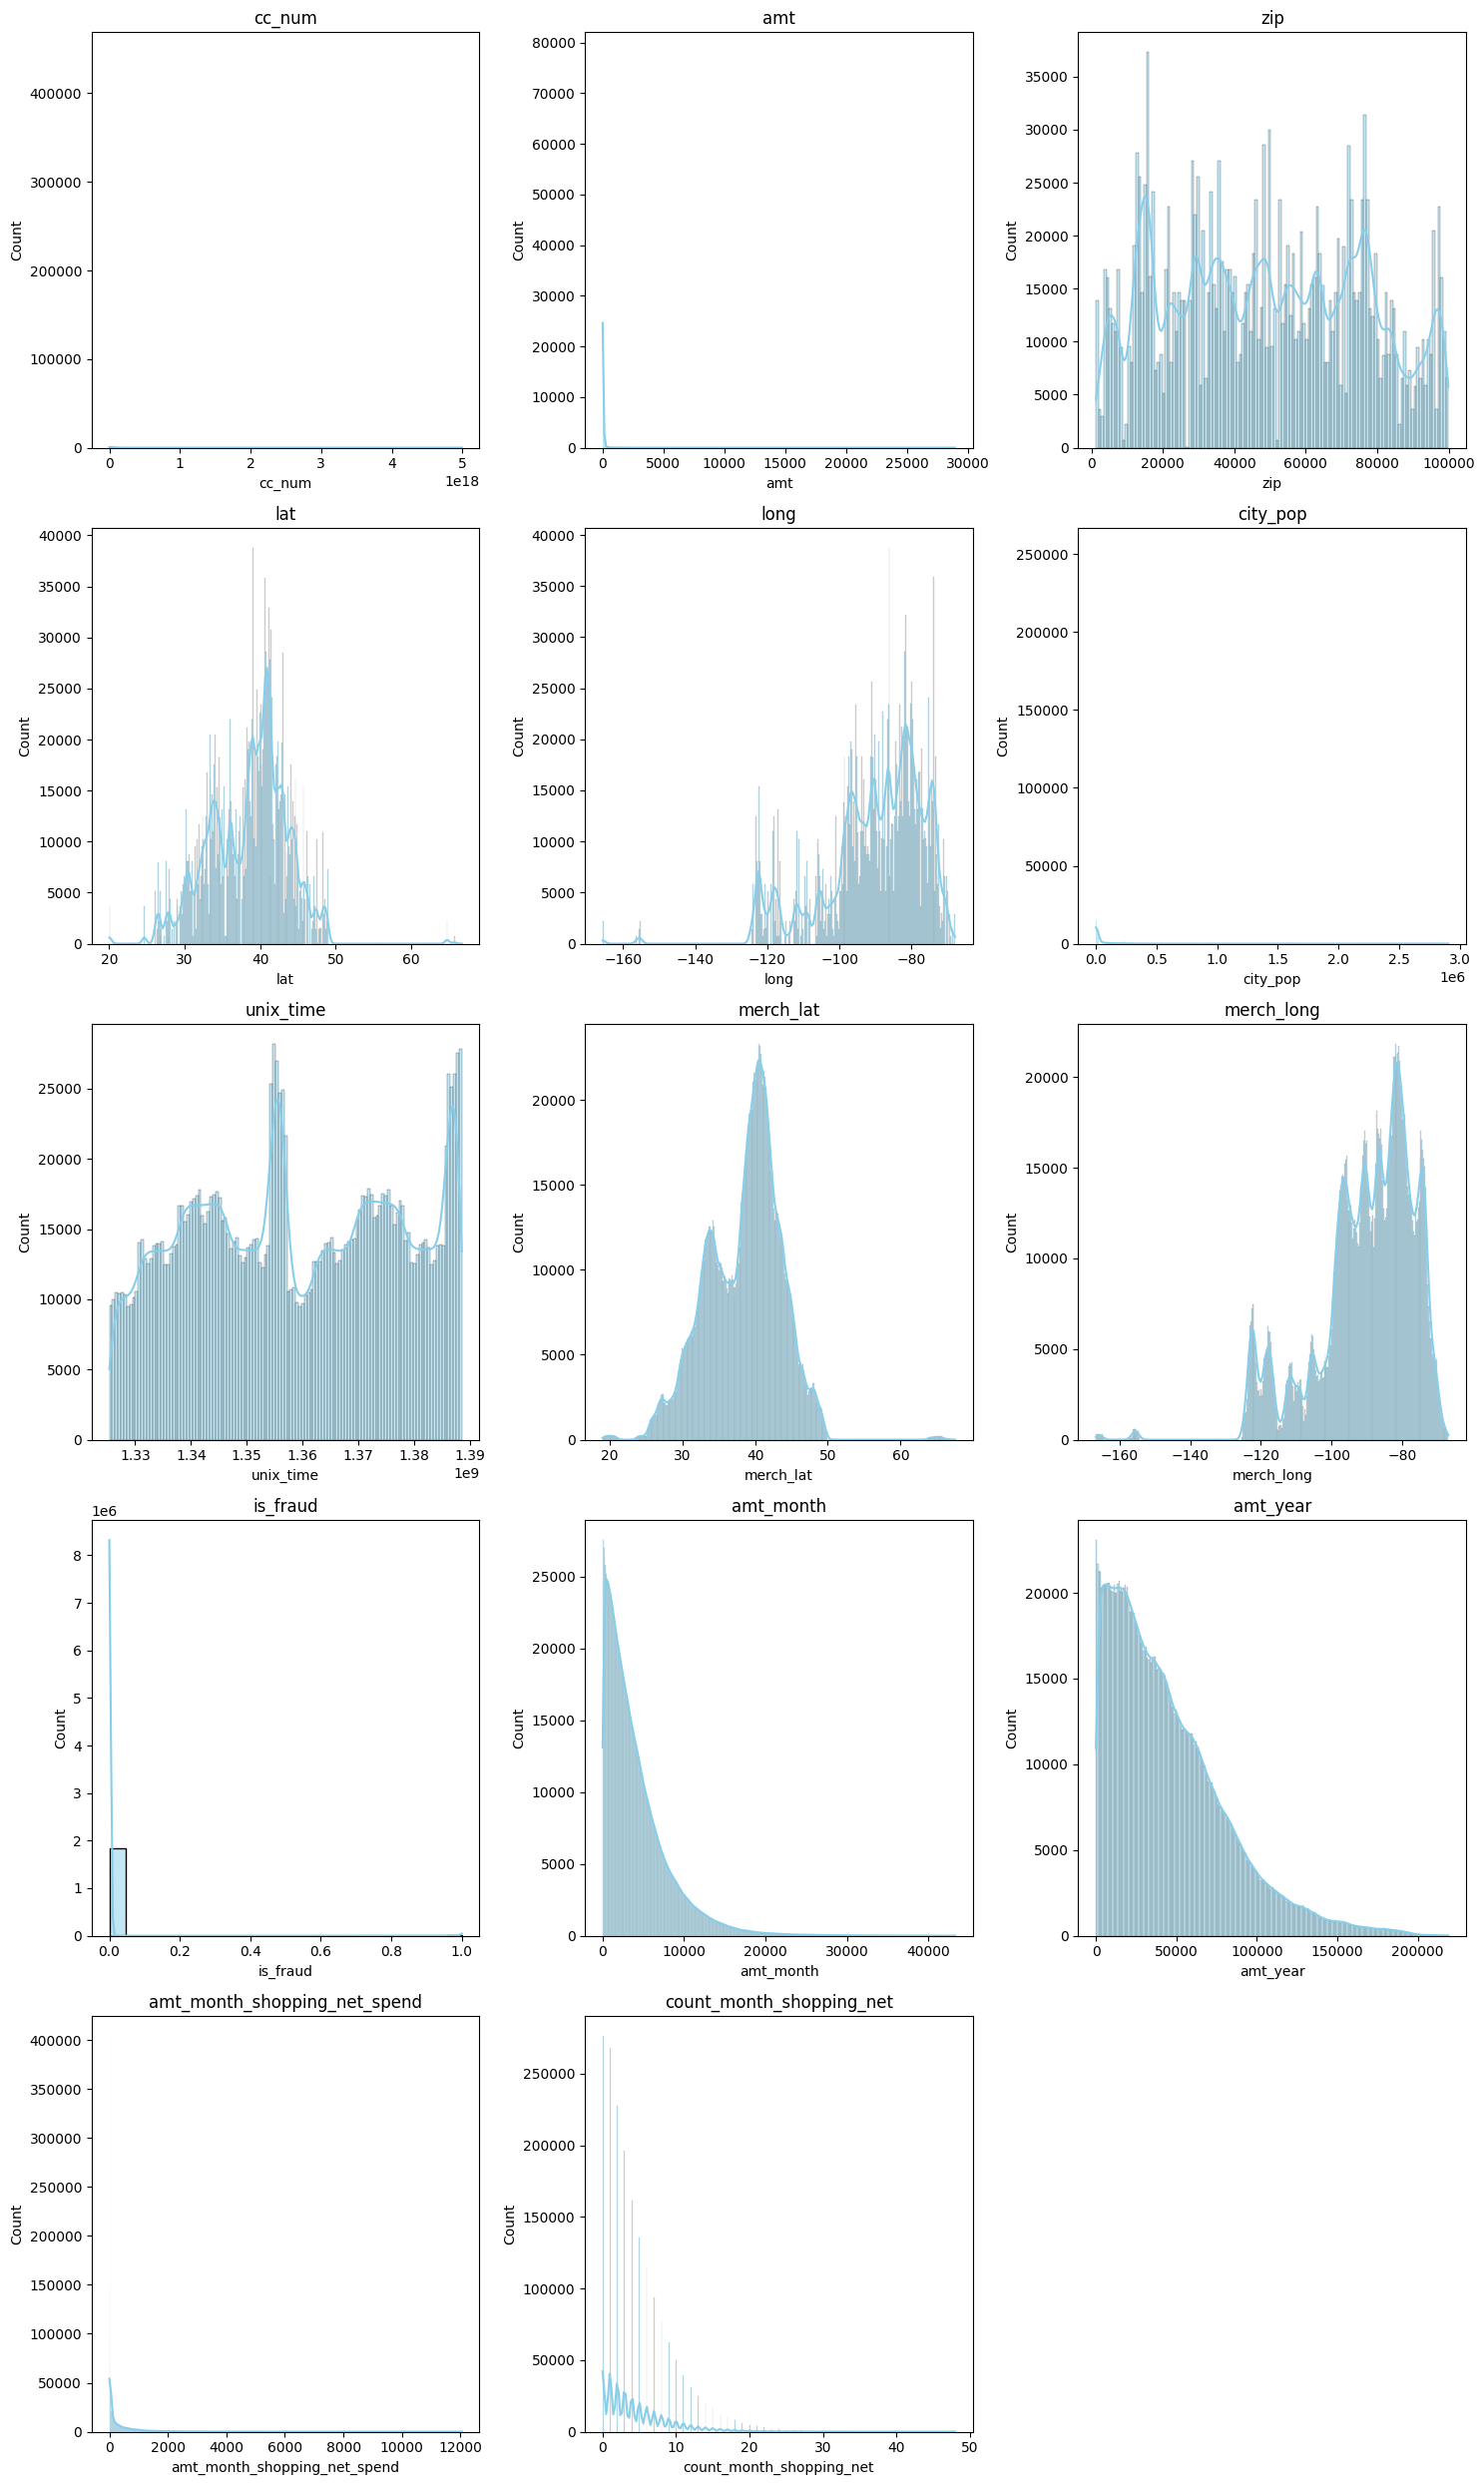

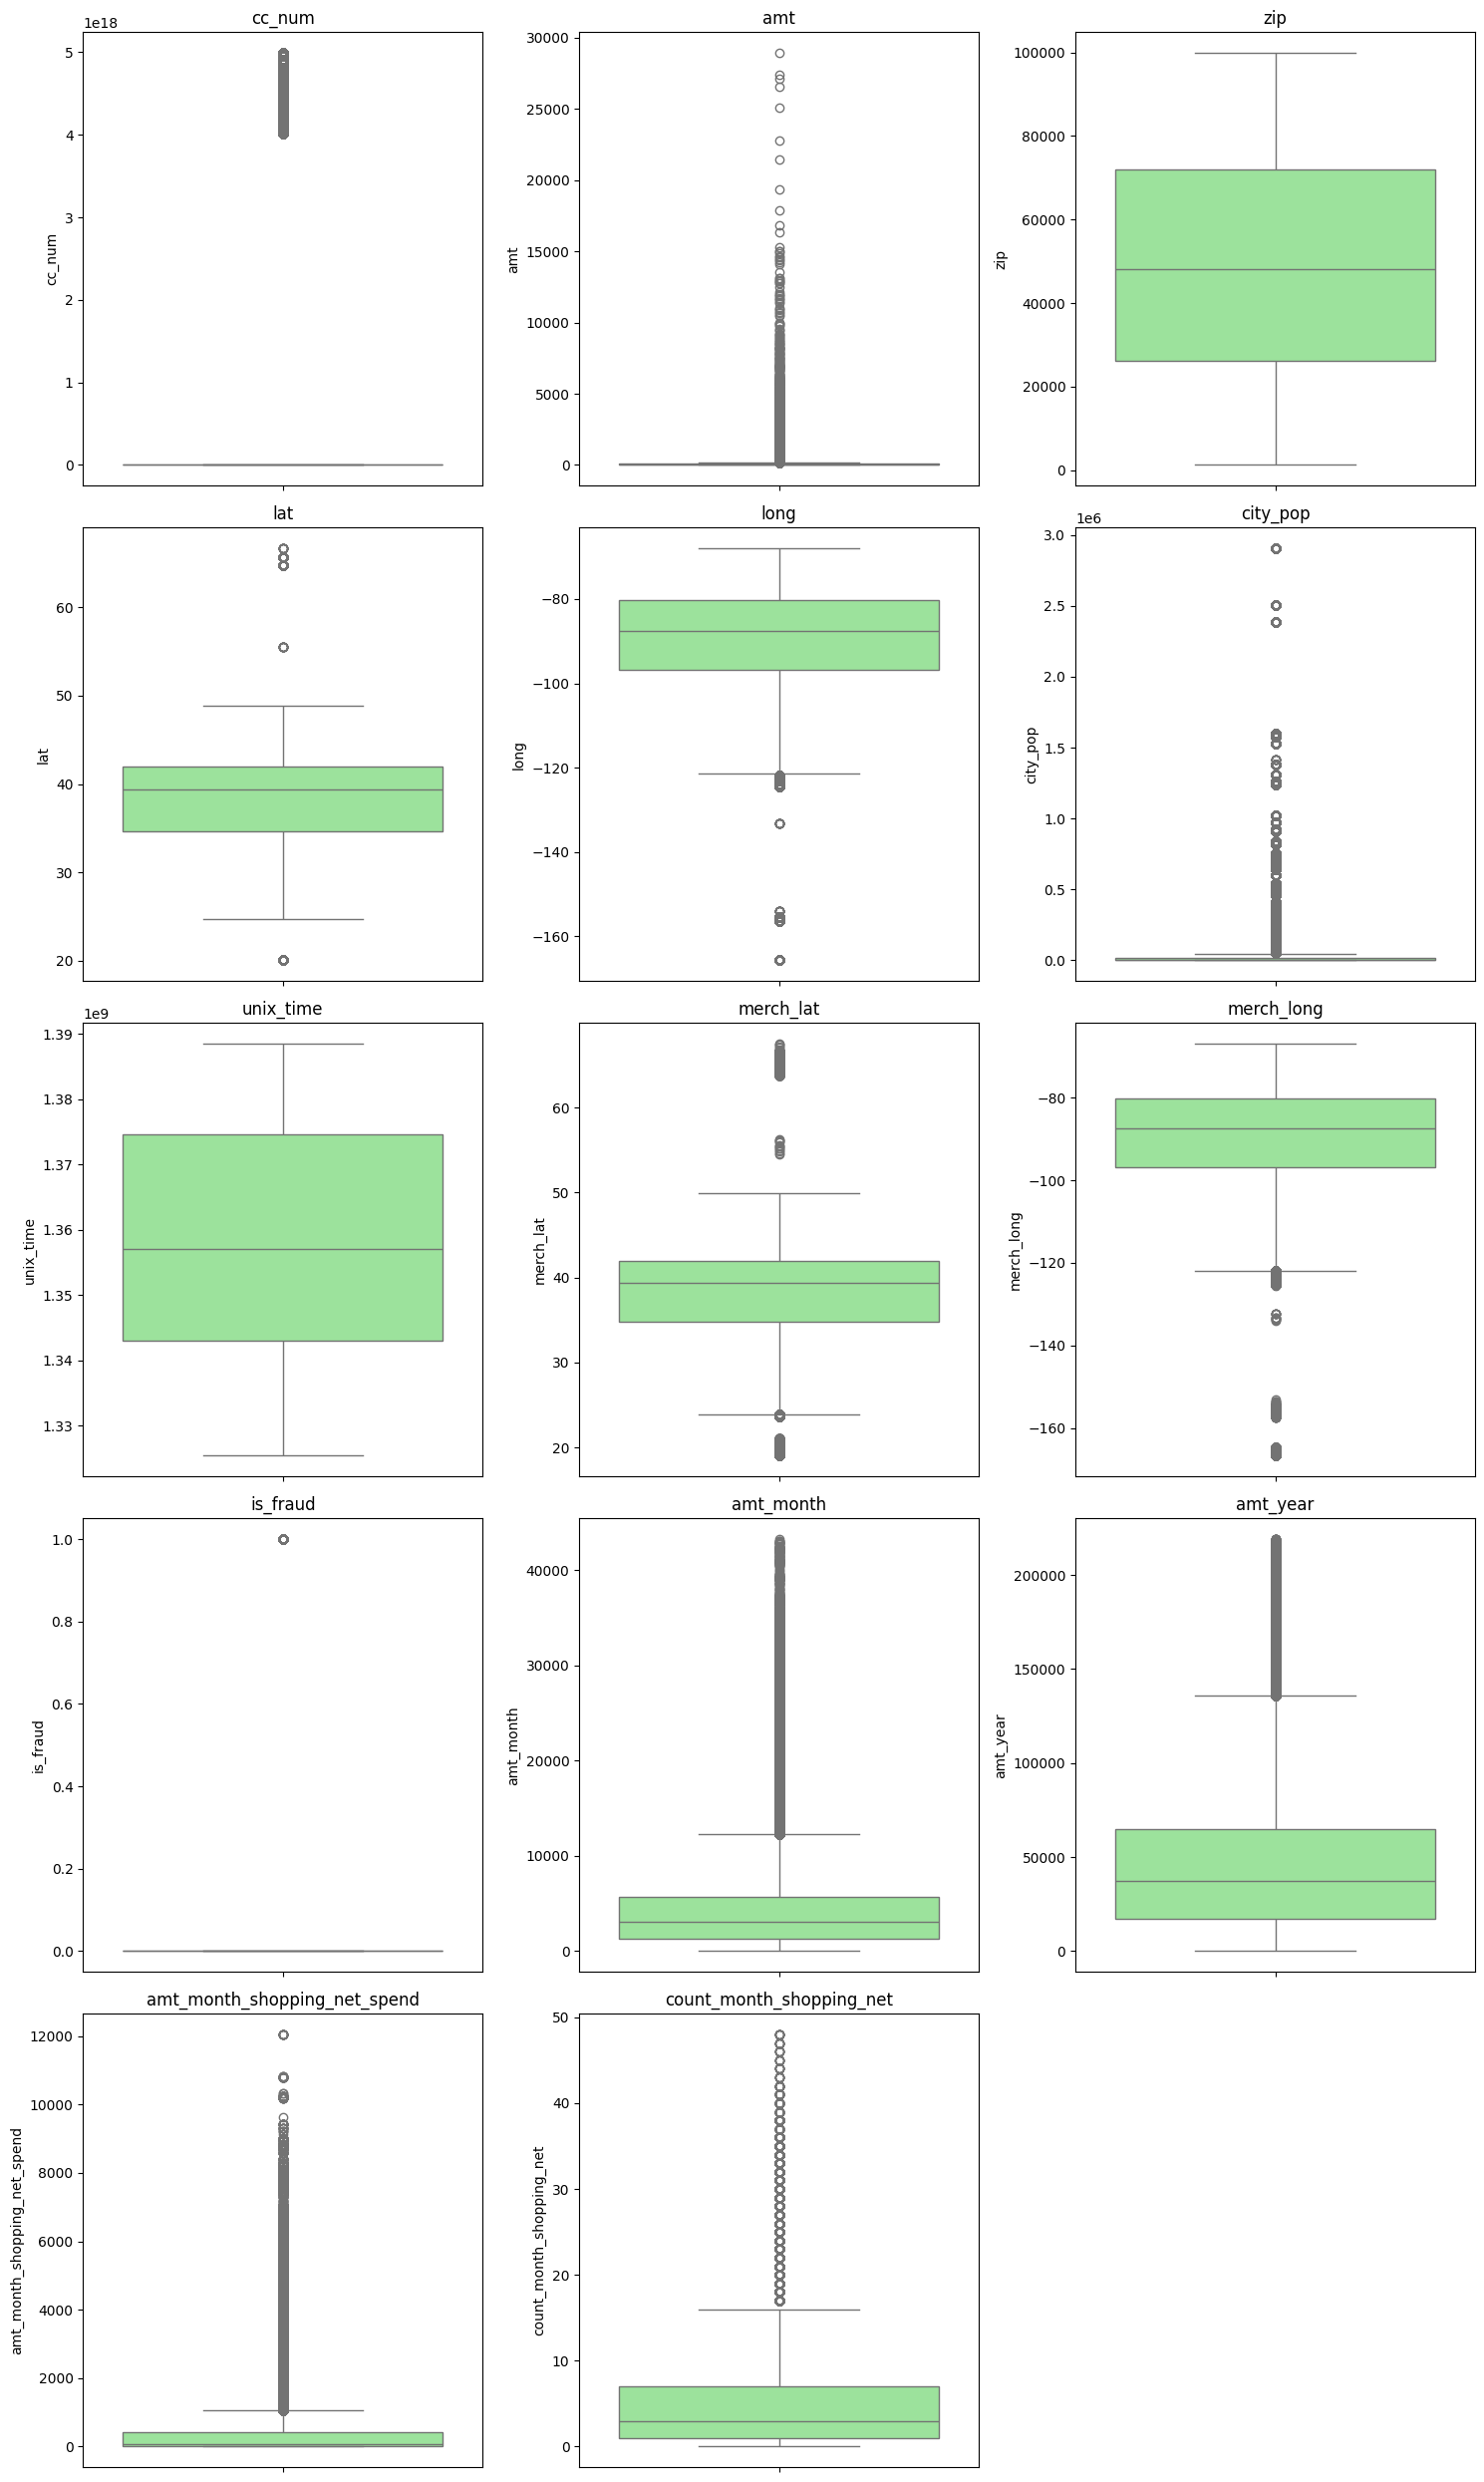

In [7]:
# Calcular el número de subgráficos necesario
num_features = len(numeric_features.columns)
num_rows = (num_features // 3) + (1 if num_features % 3 > 0 else 0)

# Visualizar distribuciones de características numéricas utilizando histogramas
plt.figure(figsize=(15, num_rows * 5))
for i, col in enumerate(numeric_features.columns):
    plt.subplot(num_rows, 3, i+1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

# Visualizar distribuciones de características numéricas utilizando boxplots
plt.figure(figsize=(15, num_rows * 5))
for i, col in enumerate(numeric_features.columns):
    plt.subplot(num_rows, 3, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(col)
plt.tight_layout()
plt.show()

#### Preprocesamiento